<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/modelling_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

## Libraries and GloVe

In [1]:
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Get GloVe from the web
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-05-14 09:15:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-14 09:15:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-14 09:15:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Binary model

### Dataset

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9572k      0  0:00:08  0:00:08 --:--:-- 15.1M


In [4]:
# Directory path
dataset_dir = "aclImdb"

# Remove unsup data (not labeled)
shutil.rmtree(os.path.join(dataset_dir, 'train', 'unsup'))

# Load training and test sets
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    batch_size=batch_size
)

# To train the Final Model
full_train_ds = train_ds.concatenate(val_ds).shuffle(10000)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
max_vocab = 20000
sequence_len = 300

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode='int',
    output_sequence_length=sequence_len
)

# Adapt vectorizer on training data
text_only_train = train_ds.map(lambda x, y: x)
vectorizer.adapt(text_only_train)

### Model 1
val_accuracy = 0.8772

In [7]:
model1 = keras.Sequential([
    vectorizer,
    layers.Embedding(input_dim=max_vocab, output_dim=128),
#    layers.GlobalAveragePooling1D(),      # either this
    layers.GlobalMaxPooling1D(),           # or this
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])

model1.compile(optimizer="adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [8]:
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model1.summary()

Epoch 1/20


ValueError: Input 0 of layer "global_max_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 2
val_accuracy = 0.8870

In [10]:
model2 = keras.Sequential([
    vectorizer,  # Text → integers
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model2.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.6175 - loss: 0.6327 - val_accuracy: 0.7790 - val_loss: 0.4380
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8542 - loss: 0.3393 - val_accuracy: 0.8452 - val_loss: 0.3457
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.8943 - loss: 0.2615 - val_accuracy: 0.8780 - val_loss: 0.3048
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9100 - loss: 0.2237 - val_accuracy: 0.8884 - val_loss: 0.2796
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9374 - loss: 0.1719 - val_accuracy: 0.8844 - val_loss: 0.2940
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9478 - loss: 0.1474 - val_accuracy: 0.8802 - val_loss: 0.3143
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.9578 - loss: 0.1173 - val_accuracy: 0.8806 - val_loss: 0.3389


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

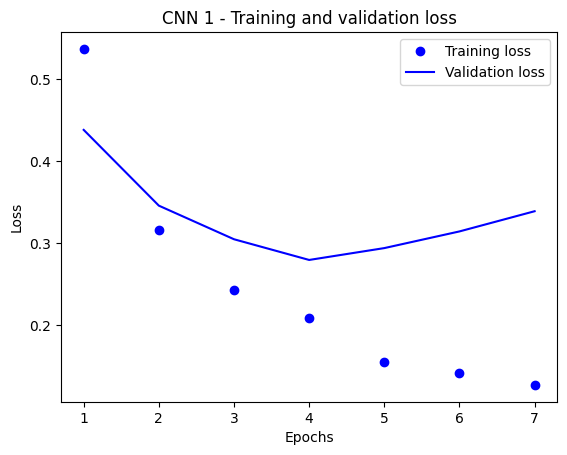

In [12]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

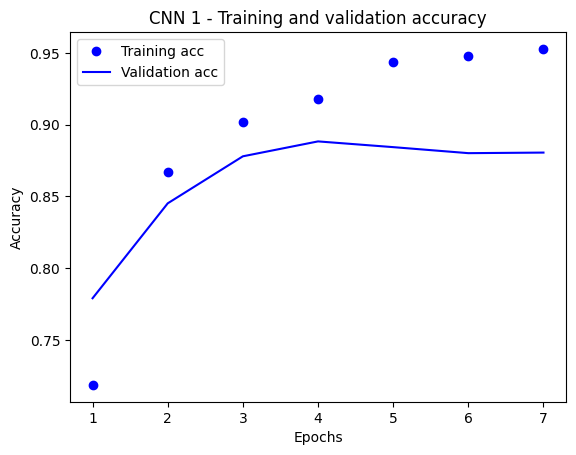

In [13]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 3
val_accuracy = 0.8720

In [14]:
embedding_dim = 100
glove_path = "glove.6B.100d.txt"

# Load GloVe
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
model3 = models.Sequential([
    vectorizer,
    layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    ),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),  # Stronger signal
    layers.GlobalMaxPooling1D(),  # Focus on the most important time steps
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

model3.summary()

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 349ms/step - accuracy: 0.6523 - loss: 0.5968 - val_accuracy: 0.8266 - val_loss: 0.3777
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 351ms/step - accuracy: 0.8403 - loss: 0.3756 - val_accuracy: 0.8532 - val_loss: 0.3294
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 348ms/step - accuracy: 0.8694 - loss: 0.3179 - val_accuracy: 0.8660 - val_loss: 0.3084
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 268s 358ms/step - accuracy: 0.8895 - loss: 0.2774 - val_accuracy: 0.8630 - val_loss: 0.3194
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 359ms/step - accuracy: 0.9065 - loss: 0.2451 - val_accuracy: 0.8684 - val_loss: 0.3146
Epoch 6/30
335/625 ━━━━━━━━━━━━━━━━━━━━ 1:35 329ms/step - accuracy: 0.9186 - loss: 0.2117

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Binary Model (model 2)

In [17]:
model_binary = keras.Sequential([
    vectorizer,
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),  # Sequence → single vector    TEST WITHOUT

    # Dense layer 1
    layers.Dense(8, activation='relu'),

    # Dense layer 2
    layers.Dense(8, activation='relu'),

    # Dense layer 3 (Output)
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model_binary.fit(
    full_train_ds,
    validation_data = test_ds,
    epochs=20,
    callbacks = [
        EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True, mode='max'),
        ModelCheckpoint('best_model_binary.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
)

model_binary.summary()

Epoch 1/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6423 - loss: 0.6101

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_AUC` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.6425 - loss: 0.6098 - val_accuracy: 0.8335 - val_loss: 0.3739
Epoch 2/20
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8768 - loss: 0.3004

782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.8769 - loss: 0.3004 - val_accuracy: 0.8606 - val_loss: 0.3238
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9101 - loss: 0.2262

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9101 - loss: 0.2262 - val_accuracy: 0.8757 - val_loss: 0.3025
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.9318 - loss: 0.1829 - val_accuracy: 0.8477 - val_loss: 0.3600
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9392 - loss: 0.1724 - val_accuracy: 0.8213 - val_loss: 0.4633
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.9475 - loss: 0.1404 - val_accuracy: 0.8354 - val_loss: 0.4368
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.9605 - loss: 0.1146 - val_accuracy: 0.8281 - val_loss: 0.5097
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9587 - loss: 0.1141 - val_accuracy: 0.8602 - val_loss: 0.4173
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9673 - loss: 0.0960 - val_accuracy: 0.8537 - val_loss: 0.4684
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9671 - loss: 0.0933 - val_accura

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,341 (29.31 MB)

 Trainable params: 2,561,113 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,122,228 (19.54 MB)

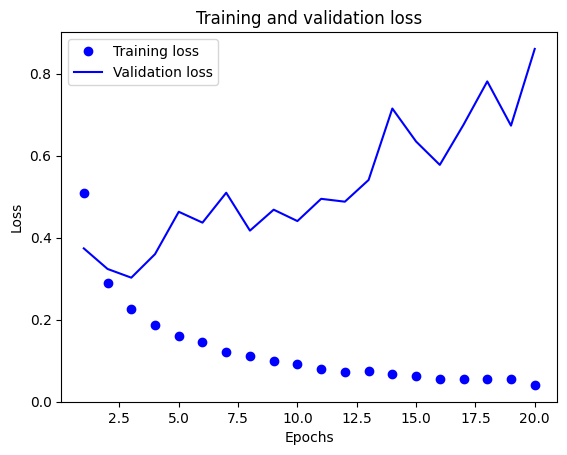

In [19]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

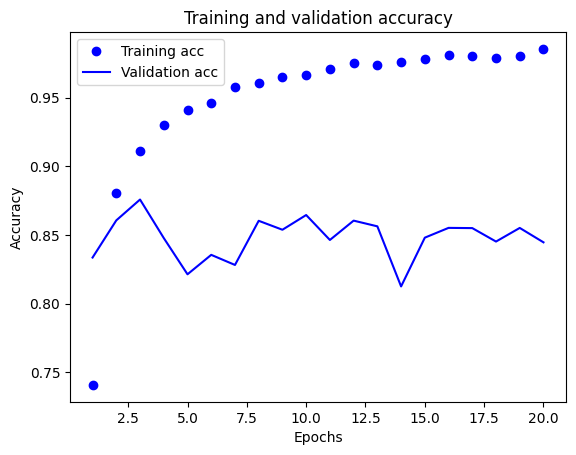

In [20]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
def predict_binary(text):
    text_tensor = tf.convert_to_tensor([text])
    pred = model_binary.predict(text_tensor)[0][0]
    return "positive" if pred >= 0.5 else "negative"

print(predict_binary("The direction and cinematography were absolutely brilliant."))
print(predict_binary("So bad I would watch it again."))
print(predict_binary("Bad."))
print(predict_binary("I did not like it."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
negative


## Multi-class model

### Dataset

In [22]:
# Unzip to a folder
!unzip emotions-goemotions.zip -d emotions_data

Archive:  emotions-goemotions.zip
   creating: emotions_data/goemotions/
  inflating: emotions_data/goemotions/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/._.DS_Store  
   creating: emotions_data/goemotions/data/
  inflating: emotions_data/__MACOSX/goemotions/._data  
  inflating: emotions_data/goemotions/data/.DS_Store  
  inflating: emotions_data/__MACOSX/goemotions/data/._.DS_Store  
   creating: emotions_data/goemotions/data/full_dataset/
  inflating: emotions_data/__MACOSX/goemotions/data/._full_dataset  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_1.csv  
  inflating: emotions_data/__MACOSX/goemotions/data/full_dataset/._goemotions_1.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_3.csv  
  inflating: emotions_data/goemotions/data/full_dataset/goemotions_2.csv  


In [23]:
dataset = pd.read_csv('emotions_data/goemotions/data/full_dataset/goemotions_1.csv')

In [24]:
dataset.drop(columns=["id","author","subreddit","link_id","parent_id","created_utc","rater_id","example_very_unclear"], inplace=True)

In [25]:
vectorizer.adapt(dataset['text'].values)

X = vectorizer(dataset['text'].values)

y = dataset.drop(columns=['text'])

In [26]:
X_numpy = X.numpy() if isinstance(X, tf.Tensor) else X
X_train_full, X_test, y_train_full, y_test = train_test_split(X_numpy, y, test_size=0.2, random_state=42)

# Second split: Take 20% of training for validation (16% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42
)

### Model 4

In [27]:
max_tokens = len(vocab)  # Size of vocabulary
embedding_dim = 100       # Must match your embedding_matrix dimension

# Create model with CNN and LSTM layers
model4 = models.Sequential([
    layers.Embedding(input_dim=max_tokens,
                     output_dim=embedding_dim,
                     embeddings_initializer=initializers.Constant(embedding_matrix),
                     trainable=False),

    layers.Conv1D(128, 5, activation='relu'),  # CNN layer with 128 filters and kernel size 5
    layers.MaxPooling1D(2),  # Max pooling to downsample

    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    layers.GlobalMaxPooling1D(),  # Global max pooling to reduce dimensionality

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='sigmoid')
])


In [28]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [29]:
# Fit the model
history = model4.fit(X_train,
                     y_train,
                     validation_data=(X_val, y_val),
                     epochs=20,
                     batch_size=64,callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, restore_best_weights=True)]
                     )

model4.summary()

Epoch 1/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 508s 708ms/step - AUC: 0.6078 - loss: 0.2425 - val_AUC: 0.7340 - val_loss: 0.1579
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 501s 709ms/step - AUC: 0.6916 - loss: 0.1658 - val_AUC: 0.7345 - val_loss: 0.1574
Epoch 3/20
522/700 ━━━━━━━━━━━━━━━━━━━━ 1:52 630ms/step - AUC: 0.6993 - loss: 0.1631

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Model 5

In [30]:
model5 = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

In [31]:
model5.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [33]:
history = model5.fit(X_train, y_train,
                     epochs=50,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True)
)
model5.summary()

Epoch 1/50
 641/1400 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - AUC: 0.6772 - loss: 0.1700

KeyboardInterrupt: 

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["AUC"]
val_acc = history_dict["val_AUC"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final Multi-class Model (model 5)

In [34]:
model_multi_class = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(28, activation='sigmoid')
])

model_multi_class.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['AUC'])

In [35]:
history = model_multi_class.fit(X_train_full,
                                y_train_full,
                                epochs=50,
                                batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks = [
                                    EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True),
                                    ModelCheckpoint('best_model_multi.h5', monitor='val_AUC', save_best_only=True, mode='max')]
)
model_multi_class.summary()

Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.6702 - loss: 0.1885

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - AUC: 0.6702 - loss: 0.1884 - val_AUC: 0.7335 - val_loss: 0.1570
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - AUC: 0.7151 - loss: 0.1592 - val_AUC: 0.7327 - val_loss: 0.1569
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7206 - loss: 0.1587

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - AUC: 0.7206 - loss: 0.1587 - val_AUC: 0.7364 - val_loss: 0.1568
Epoch 4/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7243 - loss: 0.1578

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - AUC: 0.7243 - loss: 0.1578 - val_AUC: 0.7453 - val_loss: 0.1554
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.7347 - loss: 0.1559

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 85s 37ms/step - AUC: 0.7347 - loss: 0.1559 - val_AUC: 0.7569 - val_loss: 0.1528
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.7478 - loss: 0.1542

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - AUC: 0.7478 - loss: 0.1542 - val_AUC: 0.7604 - val_loss: 0.1536
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7611 - loss: 0.1512

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - AUC: 0.7611 - loss: 0.1512 - val_AUC: 0.7798 - val_loss: 0.1488
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7696 - loss: 0.1502

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.7696 - loss: 0.1502 - val_AUC: 0.7960 - val_loss: 0.1454
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 64s 37ms/step - AUC: 0.7787 - loss: 0.1482 - val_AUC: 0.7905 - val_loss: 0.1468
Epoch 10/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.7875 - loss: 0.1463

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - AUC: 0.7875 - loss: 0.1463 - val_AUC: 0.8087 - val_loss: 0.1430
Epoch 11/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - AUC: 0.7919 - loss: 0.1457 - val_AUC: 0.8028 - val_loss: 0.1456
Epoch 12/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.7955 - loss: 0.1449

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.7955 - loss: 0.1449 - val_AUC: 0.8140 - val_loss: 0.1414
Epoch 13/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - AUC: 0.8045 - loss: 0.1431 - val_AUC: 0.8100 - val_loss: 0.1423
Epoch 14/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - AUC: 0.8021 - loss: 0.1436 - val_AUC: 0.8090 - val_loss: 0.1427
Epoch 15/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.8063 - loss: 0.1427

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 86s 36ms/step - AUC: 0.8063 - loss: 0.1427 - val_AUC: 0.8303 - val_loss: 0.1381
Epoch 16/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8091 - loss: 0.1420

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - AUC: 0.8091 - loss: 0.1420 - val_AUC: 0.8327 - val_loss: 0.1376
Epoch 17/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - AUC: 0.8151 - loss: 0.1403 - val_AUC: 0.8263 - val_loss: 0.1385
Epoch 18/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 88s 38ms/step - AUC: 0.8195 - loss: 0.1400 - val_AUC: 0.7906 - val_loss: 0.1463
Epoch 19/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8217 - loss: 0.1391

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - AUC: 0.8217 - loss: 0.1391 - val_AUC: 0.8468 - val_loss: 0.1338
Epoch 20/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - AUC: 0.8250 - loss: 0.1383 - val_AUC: 0.8451 - val_loss: 0.1342
Epoch 21/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8266 - loss: 0.1377

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - AUC: 0.8266 - loss: 0.1377 - val_AUC: 0.8526 - val_loss: 0.1322
Epoch 22/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - AUC: 0.8313 - loss: 0.1371 - val_AUC: 0.8334 - val_loss: 0.1368
Epoch 23/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - AUC: 0.8349 - loss: 0.1357 - val_AUC: 0.8427 - val_loss: 0.1359
Epoch 24/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 85s 36ms/step - AUC: 0.8348 - loss: 0.1356 - val_AUC: 0.8471 - val_loss: 0.1336
Epoch 25/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8383 - loss: 0.1350

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - AUC: 0.8383 - loss: 0.1350 - val_AUC: 0.8537 - val_loss: 0.1314
Epoch 26/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.8413 - loss: 0.1340

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - AUC: 0.8413 - loss: 0.1340 - val_AUC: 0.8641 - val_loss: 0.1286
Epoch 27/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.8427 - loss: 0.1328 - val_AUC: 0.8606 - val_loss: 0.1304
Epoch 28/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - AUC: 0.8482 - loss: 0.1321 - val_AUC: 0.8634 - val_loss: 0.1283
Epoch 29/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.8514 - loss: 0.1310

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.8514 - loss: 0.1310 - val_AUC: 0.8668 - val_loss: 0.1279
Epoch 30/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.8516 - loss: 0.1309

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - AUC: 0.8516 - loss: 0.1309 - val_AUC: 0.8698 - val_loss: 0.1269
Epoch 31/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - AUC: 0.8528 - loss: 0.1306 - val_AUC: 0.8521 - val_loss: 0.1320
Epoch 32/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8528 - loss: 0.1307

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - AUC: 0.8528 - loss: 0.1307 - val_AUC: 0.8701 - val_loss: 0.1260
Epoch 33/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.8556 - loss: 0.1293

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - AUC: 0.8556 - loss: 0.1293 - val_AUC: 0.8767 - val_loss: 0.1242
Epoch 34/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - AUC: 0.8580 - loss: 0.1291 - val_AUC: 0.8666 - val_loss: 0.1274
Epoch 35/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.8640 - loss: 0.1274

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - AUC: 0.8640 - loss: 0.1274 - val_AUC: 0.8794 - val_loss: 0.1228
Epoch 36/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.8635 - loss: 0.1271 - val_AUC: 0.8686 - val_loss: 0.1290
Epoch 37/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - AUC: 0.8624 - loss: 0.1273 - val_AUC: 0.8507 - val_loss: 0.1317
Epoch 38/50
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.8649 - loss: 0.1267

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - AUC: 0.8649 - loss: 0.1267 - val_AUC: 0.8909 - val_loss: 0.1203
Epoch 39/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - AUC: 0.8669 - loss: 0.1264 - val_AUC: 0.8825 - val_loss: 0.1239
Epoch 40/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - AUC: 0.8715 - loss: 0.1246 - val_AUC: 0.8664 - val_loss: 0.1271
Epoch 41/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - AUC: 0.8663 - loss: 0.1264 - val_AUC: 0.8740 - val_loss: 0.1254
Epoch 42/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - AUC: 0.8716 - loss: 0.1246 - val_AUC: 0.8785 - val_loss: 0.1228
Epoch 43/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 80s 35ms/step - AUC: 0.8725 - loss: 0.1239 - val_AUC: 0.8892 - val_loss: 0.1188
Epoch 44/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - AUC: 0.8720 - loss: 0.1241 - val_AUC: 0.8797 - val_loss: 0.1241
Epoch 45/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - AUC: 0.8719 - loss: 0.1246 - val_AUC: 0.8838 - val_loss: 0.1217
Epoch 46/50
1750/1750 ━━━━━━

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - AUC: 0.8754 - loss: 0.1233 - val_AUC: 0.9002 - val_loss: 0.1162
Epoch 49/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - AUC: 0.8787 - loss: 0.1227 - val_AUC: 0.8868 - val_loss: 0.1216
Epoch 50/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - AUC: 0.8781 - loss: 0.1221 - val_AUC: 0.8935 - val_loss: 0.1176


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (32, 300, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (32, 128)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 28)               │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,759,766 (29.60 MB)

 Trainable params: 2,586,588 (9.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,173,178 (19.73 MB)

## Merging **Binary** and **Multi class** models

In [37]:
# INPUTS NEED TO BE VECTORIZED PRIOR

# Rebuild binary model
model_binary = keras.Sequential([

    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_binary.load_weights('best_model_binary.h5')

# Rebuild multi-class model (expects token IDs)
model_multi_class = keras.Sequential([
    layers.Embedding(input_dim=max_vocab, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(28, activation='sigmoid')  # Multi-label
])
model_multi_class.load_weights('best_model_multi.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 0 layers, found 4 saved layers.

In [ ]:
# Define emotion labels (adjust to your actual labels)
emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
                  'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
                  'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
                  'remorse', 'sadness', 'surprise', 'neutral']

def predict_text(text, threshold=0.3):
    # Convert to batch shape and vectorize
    input_text = tf.convert_to_tensor([text])
    vectorized = vectorizer(input_text)

    # Binary sentiment
    sentiment_prob = model_binary.predict(input_text)[0][0]
    sentiment_label = 'positive' if sentiment_prob >= 0.5 else 'negative'

    # Multi-label emotion
    emotion_probs = model_multi_class.predict(vectorized)[0]
    predicted_emotions = [emotion_labels[i] for i, p in enumerate(emotion_probs) if p >= threshold]

    return {
        "text": text,
        "sentiment": sentiment_label,
        "sentiment_score": float(sentiment_prob),
        "emotions": predicted_emotions,
        "emotion_scores": {emotion_labels[i]: float(emotion_probs[i]) for i in range(len(emotion_probs))}
    }

In [ ]:
result = predict_text("I'm not happy about what happened, but I understand.")
print(result)